In [1]:
import re, os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from pandas.plotting import scatter_matrix
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from mpl_toolkits import mplot3d 

# Data Import

In [3]:
data_ori = pd.read_csv("data.csv")
data_ori = data_ori.drop('fid',axis=1)
data_ori.head()

,fua_name,road_len,pop2012,night2012,cen_dist,city_pop_total,CLC2012
0,Acireale,0.015348,7325.648926,30.059999,2692.726152,65551.67962,1
1,Acireale,0.007960,1882.117426,20.930000,2421.478762,65551.67962,1
2,Acireale,0.006610,2574.318192,18.379999,2214.927460,65551.67962,1
3,Acireale,0.011870,7405.131897,28.459999,2092.320938,65551.67962,1
4,Acireale,0.013190,11867.653830,42.959999,2068.639445,65551.67962,1


In [4]:
data = pd.read_csv("data_new.csv")
data.describe()

,pop2012,night2012,road_len,cen_dist,city_pop_total,land_cover
count,433774.000000,433774.000000,433774.000000,433774.000000,433774.000000,433774.000000
mean,0.008004,0.020648,0.071480,0.214999,0.192048,6.906518
std,0.032205,0.042011,0.093311,0.142153,0.301218,1.857292
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.001736,0.000000,0.115120,0.021847,7.000000
50%,0.000061,0.004673,0.046930,0.182038,0.036372,7.000000
75%,0.001265,0.017724,0.104343,0.279313,0.141055,8.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000


In [10]:
alist = data.columns.to_list()

## Data Analysis

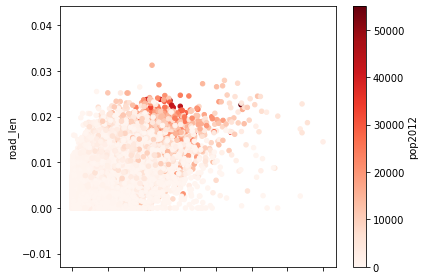

In [42]:
# Show the population distribution in Roma
Roma = data[data['fua_name']=='Roma']
Roma.plot(kind='scatter', x='night2012', y='road_len', alpha=1, c='pop2012',cmap='Reds')
plt.tight_layout()

In [11]:
# Compute pairwise correlation of columns
data[alist[:-1]].corr()

,pop2012,night2012,road_len,cen_dist,city_pop_total
pop2012,1.000000,0.634677,0.640565,-0.147956,0.142503
night2012,0.634677,1.000000,0.616371,-0.229939,0.210756
road_len,0.640565,0.616371,1.000000,-0.214231,0.111728
cen_dist,-0.147956,-0.229939,-0.214231,1.000000,0.558340
city_pop_total,0.142503,0.210756,0.111728,0.558340,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028C84703F88>,
      dtype=object)

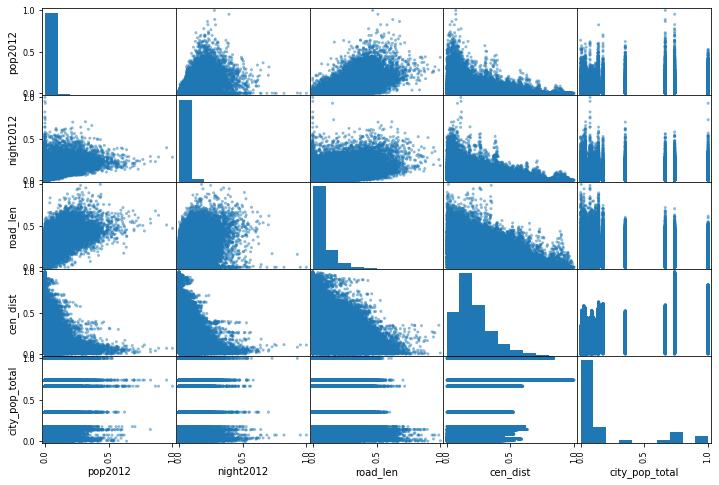

In [53]:
scatter_matrix(data_new[alist],figsize=(12,8))

In [45]:
def density_scatter(x, y, label, ax=None, sort=True, bins=20, **kwargs):
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig, ax = plt.subplots()
    data, x_e, y_e = np.histogram2d(x, y, bins=bins, density=True)
    z = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])), \
            data , np.vstack([x,y]).T, method="splinef2d", bounds_error=False)

    # To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort:
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y, c=z, **kwargs)
    ax.set_xlabel(label[0])
    ax.set_ylabel(label[1])
    norm = Normalize(vmin=np.min(z), vmax=np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax

In [46]:
x = data_new['road_len'].to_numpy()
y = data_new['night2012'].to_numpy()
z = data_new['pop2012'].to_numpy()

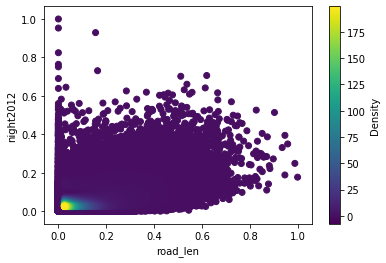

In [50]:
# 2D Version
density_scatter(x, y, label=('road_len','night2012'), bins=[20,20])

In [48]:
# %matplotlib notebook
# # calling it a second time may prevent some graphics errors
# %matplotlib notebook 

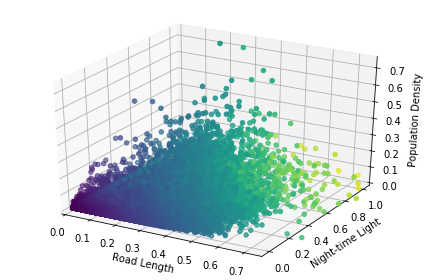

In [51]:
# 3D Version
label=('Road Length','Night-time Light','Population Density')

fig = plt.figure()
ax = plt.axes(projection='3d') 

X, Y, Z = x, y, z
c = X + Y

ax.scatter(X, Y, Z, c=c)
ax.set_xlabel(label[0])
ax.set_ylabel(label[1])
ax.set_zlabel(label[2])
ax.set_xlim([0, 0.75])
ax.set_zlim([0, 0.75])

# ax.set_title('3D Scatter Plot') 
plt.tight_layout()

## Temporary steps (Un-used for now)

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6372800  # Earth radius in meters
    
    phi1, phi2 = np.radians(lat1), np.radians(lat2) 
    dphi       = np.radians(lat2 - lat1)
    dlambda    = np.radians(lon2 - lon1)
    
    a = np.sin(dphi/2)**2 + \
        np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    
    return 2*R*np.arctan2(np.sqrt(a), np.sqrt(1 - a))

In [ ]:
data['cen_dist'] = haversine(data['X'],data['Y'],data['X_cen'],data['Y_cen'])

In [ ]:
# # Based on different city_id, to normalize the longitude and latitude
# alist = ['X','Y']
# for col in alist:
#     data[col+'_max'] = data.groupby(['city_id'])[col].transform(max)
#     data[col+'_min'] = data.groupby(['city_id'])[col].transform(min)
#     data_new[col] = ((data[col] - data[col+'_min']) / (data[col+'_max'] - data[col+'_min']))

In [ ]:
dscb_dict = data.describe().to_dict()
night_min = 0
night_max = dscb_dict['night2012']['max']

In [ ]:
# Normalize the night-light in different time with the same standard.
alist = ['night2012',]
for col in alist:
    data_new[col] = data[col].apply(lambda x: (x - night_min) / (night_max - night_min))